# Neural and Evolutionary Learning - Final Project

## Notebook 2 - Problem Applications

## **2.1.** *Genetic Programming* - `GP`

|       Student Name      |    Student ID   |
|           ---           |       ---       |
|     Andriani Kakoulli   |     20230484    |
|       Susana Pires      |     20230540    |

### **1. Introduction**

> **CONTEXT** <br>

Data from Automatic Milking Systems (AMSs). <br>

Milk contents (fat, protein, lactose) are emasured at each milking event, to evaluate milk quality. This measurement is through a colourimetric mehtod that requires calibration every 2 weeks. <br>

> **GOAL** <br>

To infer the milk components - *Lactose* - from the other sensor data from the milking robots. <br>
Develop model to **predict** Lactose content.

> **GPOL**-based implementations

> **1.** **Search Space** definition <br>
> Python dictionary with following elements: <br>
> - *n_dims*  <br>
> - *function_set*  <br>
> - *constant_set*  <br>
> - *p_constants*  <br>
> - *max_init_depth*  <br>
> - *max_depth*  <br>
> - *n_batches*  <br>
> - *device*  <br>
> <br>
> 
> **2.** **Problem Instance** definition  <br>
> Instantiantion of a SML (supervised-ML) object, it requires:  <br>
> - *fitness function*  <br>
> - *train data loader*  <br>
> - *number of jobs for parallel processing* <br>
> Optional: can take test data loader object.  <br>
> <br>
>
> **3.** **Algorithm** definition  <br>
> Instantiation of a Genetic Algorithm object, requires definitions of:  <br>
> - *problem instance*  <br>
> - *initialization methods*  <br>
> - *crossover operators*  <br>
> - *mutation operators*  <br>
> - *crossover probabilities*  <br>
> - *mutation probabilities*  <br>
> - *elitism*  <br>
> - *reproduction*  <br>
> - *device on evaluations will be processed*  <br>
> - *random seed*  <br>

### **2. Environment preparation**

#### **2.1. Imports**

In [9]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

# import from other files on folders
# algorithms, operators, problems, utils

from gpolnel.utils.utils import train_test_split
from gpolnel.utils.utils import load_cleaned_data, load_cleaned_transformed_data

# For 2.5.1 Search space definition
from gpolnel.utils.inductive_programming import function_map
from gpolnel.operators.initializers import ERC
# For 2.5.2 Problem definition
from gpolnel.problems.inductive_programming import SML
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import _execute_tree
##############################
# For 2.5.3 GP instalation
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers_for_GP import grow, prm_grow, full, prm_full, rhh
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn, hoist_mtn
from gpolnel.operators.selectors import prm_tournament, rank_selection, roulette_wheel

#### **2.2. Global settings**

In [10]:
seed = 27

# Susana - my device will always be cpu because my pc doesn't have a NVIDIA (nor a recent AMD) GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# if Mac
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# if Windows
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### **2.3. Data load**

To use the data loader<br>
- folder *problems* - file *problem* <br>
- folder *utils* - file *solution* <br>
- the data loader is instantiated inside SML (folder *problems* in file *inductive_programming*) <br>

In [11]:
X, y = load_cleaned_data(X_y=True)

In [12]:
print(X.shape, y.shape)

torch.Size([177, 14]) torch.Size([177])


#### **2.4. Data split**

In [13]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.3, seed=seed)

# Train and validation sets, load from X_train and y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, p_test=0.3, seed=seed)
total_batches = 1 
batch_size = X_train.shape[0]
print(f'Batch size: {batch_size}\nTotal batches: {total_batches}\n')

print(f'Train:\t{X_train.shape[0]}\nVal:\t{X_val.shape[0]}\nTest:\t{X_test.shape[0]}')
print('Total:\t{}'.format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))

Batch size: 87
Total batches: 1

Train:	87
Val:	37
Test:	53
Total:	177


In [14]:
# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_val, y_val)

# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

#### **2.5. GPOL Based Implementation**

##### 2.5.1 Search Space Definition (Step 1)

In [15]:
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

sspace_sml = {  # search space definition
    'n_dims': X.shape[1],
    'function_set': fset, 
    'constant_set': ERC(-1., 1.), # ERC generates random constants
    'p_constants': 0.1, # probability of using a constant = 10% , bcs the features will be more informative
    'max_init_depth': 3,
    'max_depth': 10, 
    'n_batches': total_batches,
    'device': device
}

##### 2.5.2 Problem Definition (Step 2)

In [16]:
pi_sml = SML(
    sspace=sspace_sml,
    ffunction=Ffunctions('rmse'), # def of fitness function (rmse: decrese the error as it's a prediction problem) |we can use another fitness function - decision is problem dependent
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!!
    n_jobs=8  # defines the num of paralellized operations (eg fitness). it is a dataloader form torch  
)

##### 2.5.3 Genetic Algorithm Definition (Step 3)

In [17]:
ps = 100  # Modify this number 10 or 100
selection_pressure = .07
mutation_prob = .1     #}   # pc + pm =1
xo_prob = .9           #}
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=full,  # We can choose among grow, full, ramped half&half(givesNone)
    selector=prm_tournament(pressure=selection_pressure),  # We can choose another selection: try double tourn to avoid the tree growing too much
    crossover=swap_xo,
    mutator=prm_subtree_mtn(initializer=prm_full(sspace_sml)),  # prm methods of initializers - to avoid using if statements
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed
)

#### **2.6. Genetic Programming Initialization**

In [18]:
mheuristic._initialize(tree=True)

In [19]:
print(mheuristic.pop)

0)	[div, mul, mul, 1, 8, mul, 13, 2, sub, sub, 1, 10, add, 6, 11] (fit: tensor(2510.5195))
1)	[add, div, mul, tensor(0.9489), 4, sub, 5, 3, sub, add, 12, 11, add, 8, tensor(-0.0809)] (fit: tensor(7.4066))
2)	[sub, mul, add, 10, tensor(0.5594), mul, 9, 4, div, div, 5, 4, sub, 8, tensor(-0.5015)] (fit: tensor(40.1837))
3)	[sub, div, add, 12, tensor(-0.3125), add, 12, 11, add, mul, 4, 9, add, 3, 7] (fit: tensor(82.8451))
4)	[add, add, add, 3, 9, add, tensor(-0.1542), 11, add, sub, 13, 0, sub, 3, 11] (fit: tensor(143.6586))
5)	[mul, div, add, 0, 13, add, 2, 9, div, add, 5, 0, div, 8, 13] (fit: tensor(890.7717))
6)	[div, mul, sub, 12, 11, mul, 11, tensor(-0.5464), div, add, 5, 2, add, 1, 3] (fit: tensor(4.8768))
7)	[sub, add, sub, 0, 8, div, 3, 8, sub, add, 8, 7, mul, 8, 11] (fit: tensor(14.9808))
8)	[sub, sub, add, 8, 5, div, 1, 1, add, sub, tensor(0.2096), 1, div, 11, 10] (fit: tensor(538.4623))
9)	[div, mul, div, 9, 1, div, 11, 4, div, sub, 10, 8, sub, 5, 11] (fit: tensor(68.1132))
10)	[

In [20]:
print(mheuristic.pop.individuals[0].repr_)

[div, mul, mul, 1, 8, mul, 13, 2, sub, sub, 1, 10, add, 6, 11]


In [21]:
print(mheuristic.pop.individuals[1].repr_)

[add, div, mul, tensor(0.9489), 4, sub, 5, 3, sub, add, 12, 11, add, 8, tensor(-0.0809)]


#### **2.7. GP Population**

In [22]:
print(f'\nGP population: {mheuristic.pop.__class__} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

for i in range(3):
    print(f'Individual {i}: {mheuristic.pop.individuals[i].repr_}, fitness {mheuristic.pop.individuals[i].fit}') # how to access the fitness - you need to explore the code more

print(f'\nGP best individual {mheuristic.best_sol.printTree(out="string")}, fitness {mheuristic.best_sol.fit}\n\n')



GP population: <class 'gpolnel.utils.population.PopulationTree'> (100 individuals)

Poppulation fitness tensor([2510.5195,    7.4066,   40.1837])...
Poppulation valid [True, True, True]...

Individual 0: [div, mul, mul, 1, 8, mul, 13, 2, sub, sub, 1, 10, add, 6, 11], fitness 2510.51953125
Individual 1: [add, div, mul, tensor(0.9489), 4, sub, 5, 3, sub, add, 12, 11, add, 8, tensor(-0.0809)], fitness 7.406620025634766
Individual 2: [sub, mul, add, 10, tensor(0.5594), mul, 9, 4, div, div, 5, 4, sub, 8, tensor(-0.5015)], fitness 40.183658599853516

GP best individual sub( div( sub( x_9, x_6 ) sub( x_2, x_13 ) ) sub( add( 0.1103, -0.0268 ) sub( x_8, x_12 ) ) ), fitness 2.4600532054901123




#### **2.8. Solve**

In [23]:
# Log settings
file_dir = './log/'
file_name = 'intro.log'
log_path = file_dir + file_name
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

In [24]:
# Learning
n_iter = 100
mheuristic.solve(
    n_iter,
    tol=0.0001,
    verbose=3, log=3, log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 15       1.34769          1.86407               0.220 | 1.70061e+07           1.65937e+08
1          | 27       0.814253         0.752403              0.181 | 588.511                   3851.17
2          | 27       0.814251         0.752403              0.182 | 702.399                   4238.31
3          | 15       0.787592         0.728088              0.138 | 34.1425                   164.302
4          | 15       0.785111         0.728686              0.237 | 

In [25]:
mheuristic.best_sol.printTree()

sub( x_4, div( div( mul( x_1, mul( div( x_7, 0.7388 ) sub( x_7, x_12 ) ) ) sub( x_4, div( div( mul( add( x_0, sub( x_7, x_12 ) ) 0.8512 ) sub( x_7, x_12 ) ) sub( x_8, div( mul( -0.2204, x_9 ) mul( -0.2204, x_9 ) ) ) ) ) ) sub( x_8, x_3 ) ) )


#### **Notes by hand - Initial exploration**

Experimenting with different combinations of selectors, initializers and elitism

##### Selectors<br>

**prm_tournament**<br>
n_iter=50<br>
- with elitism=False = 0.506  -  0.546  - 0.473
- with elitism=True = 0.627  -  0.708  -  0.567<br>

n_iter=100
- with el=False = 0.470  - 0.527  - 0.502
- with el=True = 0.498  -  0.558  -  1.085<br>

n_iter=150
- with el=False = 0.283  - 0.352  - 0.816
- with el=True = 0.336  -  0.393  -  1.244<br>

= we can see that after 50 iterations and *without elitism* the changes are very small, so we'll stick to n_iter=50 as implemented in class<br>
while *with elitism* the changes are small and steadily for all iterations<br>
= we can see that with elitism at n_iter=50 we get worse results<br>
<br>

**Rank Selection**<br>
gives worse results in n_iter=100 of
- with elitism=True = 0.689  -  0.687  -  0.307
- with elitism=False = 0.804  -  0.761  -  0.283<br>
<br>

**Roulette wheel**<br>
n_iter=100
- with el=True = (gets stuck at iter=89)  0.579 - 0.480 - 0.289
- with el=False = (gets stuck at ietr=40) 1.43 - 1.26 - 0.307

__________________________________________________<br>
***Conclusion***:
- Rank Sel : highest numbers and probably overfittng
- Roulette : not the best results ( better with elitism) - overfits
- Tournam : best results(without elitism) - no overfitting

**=> Tournament without elitism**

##### Initializers

n_iter=50

**grow**<br>
0.506 - 0.546 - 0.507

**full**<br>
0.202 - 0.225 - 0.492


**=> FULL initializer**

#### **2.9 Evolution of GP**

In [26]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Val fitness history
history_val_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [int(row[6]) for row in rows]

# Runtime
history_timing = [float(row[5]) for row in rows]


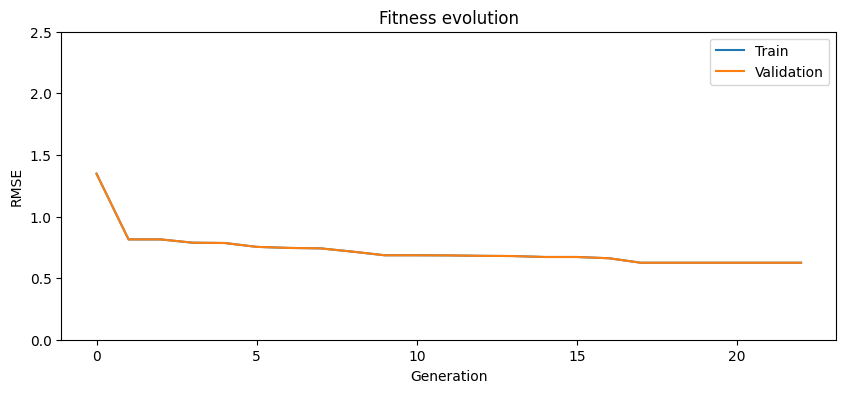

In [27]:
# Plotting the evolution of fitness(=RMSE)
plt.figure(figsize=(10, 4))
plt.plot(history_fits, label='Train')
plt.plot(history_val_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0, top=2.5)
plt.legend()
plt.show()

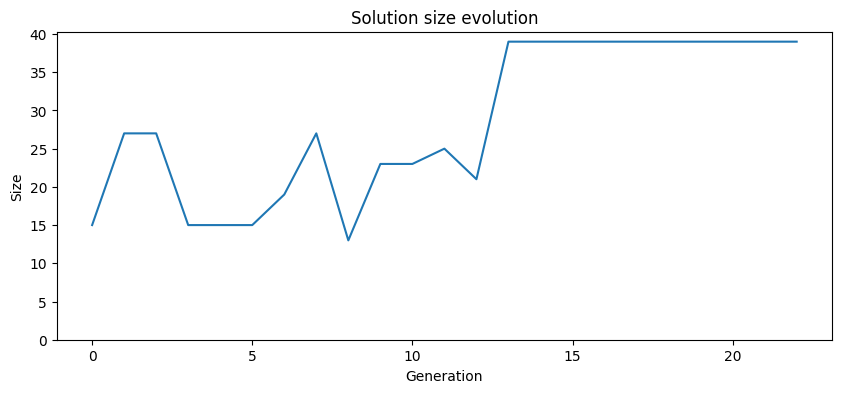

In [28]:
# Plotting the evolution of the solution size
plt.figure(figsize=(10, 4))
plt.plot(history_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()

#### **2.10 Evaluation of GP**

In [72]:
# Set the best solution of the population
mheuristic._set_best_sol()

In [73]:
# Evaluate the final solution
best_individual = mheuristic.best_sol
best_solution = best_individual.repr_

In [74]:
# Using the best solution for predictions on the test set
ds_test = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)
y_pred = pi_sml.predict_sol_data_loader(best_solution, dl_test, device)

C:\Users\andri\AppData\Local\Temp\ipykernel_8988\2231323160.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))


In [75]:
# Compute the final performance on the test set
final_rmse = torch.sqrt(torch.mean((y_pred - torch.tensor(y_test, dtype=torch.float32).to(device)) ** 2)).item()
print(f'Final RMSE on test set: {final_rmse}')

Final RMSE on test set: 0.6897413730621338


C:\Users\andri\AppData\Local\Temp\ipykernel_8988\3564359875.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_rmse = torch.sqrt(torch.mean((y_pred - torch.tensor(y_test, dtype=torch.float32).to(device)) ** 2)).item()


#### **Experimenting with different combinations of selectors, initializers and elitism**
Combinations of parameters / gridsearch
- initializer = ['grow', 'full']
- population size: ps = [10, 100]
- elitism = ['True', 'False']

Run 10 times by hand  => get fintess (rmse) => median(RMSE)

In [97]:
import pandas as pd
# manually insterting RMSE of each run and each combination
combinations = {
    'grow|ps=10|elitism=True': ['0.6079107522964478', ' 1.5609365701675415', '0.9192346334457397', '2.6489524841308594', '1.9101682901382446', '1.5929198265075684', '2.0614712238311768', '2.1674251556396484', '2.0538084506988525', ' 1.24635648727417'],
    'grow|ps=10|elitism=False': ['2.03010630607605', '4.458568572998047', '3.875152826309204', '4.332056045532227', ' 3.5882136821746826', '4.0282769203186035', '1.6652990579605103', '4.78485631942749', '2.274578809738159', ' 2.141103506088257'],

    'grow|ps=100|elitism=True': ['0.6079107522964478', '1.244410753250122', '0.5319039821624756', '0.5805721282958984', '0.5707070827484131', '0.5806238651275635', '0.6897413730621338', '0.6079107522964478', '0.6079107522964478', '0.6158340573310852'],
    'grow|ps=100|elitism=False': ['0.6079107522964478', '0.6079107522964478', '0.5918365716934204', '0.600180983543396', '0.5516688227653503', '0.603151798248291', '0.6079107522964478', '0.6079107522964478', '0.6897413730621338', '0.6059889197349548'],

    'full|ps=10|elitism=True': ['1.5654094219207764', '2.8164222240448', '2.1674251556396484', '1.3267796039581299', '2.1674251556396484', '1.5654094219207764', '0.6079107522964478', '0.6079107522964478', '3.2683098316192627', '1.5393543243408203'],
    'full|ps=10|elitism=False': ['4.87506103515625', '2.7205066680908203', '4.8767242431640625', '6.266987323760986', '3.875152826309204' , '2.8164222240448', '61.43903350830078', '2.0218346118927', '4.875058650970459', '4.472360610961914'],
    
    'full|ps=100|elitism=True': ['0.5493314266204834', '0.47119712829589844', '0.608669102191925', '0.7458630800247192', '0.4773491322994232', '0.26259058713912964', '0.8935564756393433', '0.5121418237686157', '0.3910347521305084', '0.6897413730621338'],
    'full|ps=100|elitism=False': ['0.8121924996376038', '0.5505290031433105', '2.322157144546509', '0.47570231556892395', '0.367538183927536', '1.117729902267456', '0.6079107522964478', '0.5745278596878052', '0.3378094434738159', '0.3646569848060608']
}
df_combo = pd.DataFrame(combinations).T

# add the 'Runs' as columns
df_combo.columns = [f'Run_{i+1}' for i in range(len(df_combo.columns))]
df_combo.rename(columns={'index': 'Runs'}, inplace=True)

# display the updated df
df_combo

,Run_1,Run_2,Run_3,Run_4,Run_5,Run_6,Run_7,Run_8,Run_9,Run_10
grow|ps=10|elitism=True,0.6079107522964478,1.5609365701675415,0.9192346334457397,2.6489524841308594,1.9101682901382446,1.5929198265075684,2.0614712238311768,2.1674251556396484,2.0538084506988525,1.24635648727417
grow|ps=10|elitism=False,2.03010630607605,4.458568572998047,3.875152826309204,4.332056045532227,3.5882136821746826,4.0282769203186035,1.6652990579605103,4.78485631942749,2.274578809738159,2.141103506088257
grow|ps=100|elitism=True,0.6079107522964478,1.244410753250122,0.5319039821624756,0.5805721282958984,0.5707070827484131,0.5806238651275635,0.6897413730621338,0.6079107522964478,0.6079107522964478,0.6158340573310852
grow|ps=100|elitism=False,0.6079107522964478,0.6079107522964478,0.5918365716934204,0.600180983543396,0.5516688227653503,0.603151798248291,0.6079107522964478,0.6079107522964478,0.6897413730621338,0.6059889197349548
full|ps=10|elitism=True,1.5654094219207764,2.8164222240448,2.1674251556396484,1.3267796039581299,2.1674251556396484,1.5654094219207764,0.6079107522964478,0.6079107522964478,3.2683098316192627,1.5393543243408203
full|ps=10|elitism=False,4.87506103515625,2.7205066680908203,4.8767242431640625,6.266987323760986,3.875152826309204,2.8164222240448,61.43903350830078,2.0218346118927,4.875058650970459,4.472360610961914
full|ps=100|elitism=True,0.5493314266204834,0.47119712829589844,0.608669102191925,0.7458630800247192,0.4773491322994232,0.26259058713912964,0.8935564756393433,0.5121418237686157,0.3910347521305084,0.6897413730621338
full|ps=100|elitism=False,0.8121924996376038,0.5505290031433105,2.322157144546509,0.47570231556892395,0.367538183927536,1.117729902267456,0.6079107522964478,0.5745278596878052,0.3378094434738159,0.3646569848060608


In [99]:
# convert the string values to floats
df_combo.iloc[:, 1:] = df_combo.iloc[:, 1:].astype(float)

# calculate the median and mean for each row (excluding the first column)
medians = df_combo.iloc[:, 1:].median(axis=1)
avg = df_combo.iloc[:, 1:].mean(axis=1)

# Add the median values as a new column named 'Median RMSE'
df_combo['Median RMSE'] = medians
df_combo['Avg RMSE'] = avg

# Display the updated DataFrame
df_combo

,Run_1,Run_2,Run_3,Run_4,Run_5,Run_6,Run_7,Run_8,Run_9,Run_10,Median RMSE,Avg RMSE
grow|ps=10|elitism=True,0.6079107522964478,1.560937,0.919235,2.648952,1.910168,1.59292,2.061471,2.167425,2.053808,1.246356,1.910168,1.807144
grow|ps=10|elitism=False,2.03010630607605,4.458569,3.875153,4.332056,3.588214,4.028277,1.665299,4.784856,2.274579,2.141104,3.875153,3.502326
grow|ps=100|elitism=True,0.6079107522964478,1.244411,0.531904,0.580572,0.570707,0.580624,0.689741,0.607911,0.607911,0.615834,0.607911,0.663753
grow|ps=100|elitism=False,0.6079107522964478,0.607911,0.591837,0.600181,0.551669,0.603152,0.607911,0.607911,0.689741,0.605989,0.605989,0.607229
full|ps=10|elitism=True,1.5654094219207764,2.816422,2.167425,1.32678,2.167425,1.565409,0.607911,0.607911,3.26831,1.539354,1.565409,1.763236
full|ps=10|elitism=False,4.87506103515625,2.720507,4.876724,6.266987,3.875153,2.816422,61.439034,2.021835,4.875059,4.472361,4.472361,9.783644
full|ps=100|elitism=True,0.5493314266204834,0.471197,0.608669,0.745863,0.477349,0.262591,0.893556,0.512142,0.391035,0.689741,0.512142,0.556429
full|ps=100|elitism=False,0.8121924996376038,0.550529,2.322157,0.475702,0.367538,1.11773,0.607911,0.574528,0.337809,0.364657,0.550529,0.726909


Comparing the median and mean of the 10 runs of each combination, it is obvious that the best combination for GP to give the lowest fitness (RMSE) is:
- selector = full
- population size = 100
- with elitism

> ##### **median RMSE on test set:** 0.512142
> ##### **RMSE vector for statistical tests:
> RMSE_GP =[0.5493314266204834, 0.47119712829589844, 0.608669102191925, 0.7458630800247192, 0.4773491322994232, 0.26259058713912964, 0.8935564756393433, 0.5121418237686157, 0.3910347521305084, 0.6897413730621338]
